<a href="https://colab.research.google.com/github/mkm-world/Loan-Credit-Worthiness-Prediction/blob/main/Loan_Credit_Worthiness_Prediction_Starter_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Loan Creditworthiness: Baseline Approach


This starter notebook provides a baseline, simple approach to the Bluechip Data & AI 2024 Summit Hackathon on **Predicting Loan Creditworthiness**.

## Import Libraries

In [11]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


import warnings
warnings.filterwarnings('ignore')

# import models
from scipy.interpolate import PchipInterpolator
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction import DictVectorizer
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.tree import export_text
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve, average_precision_score

## Loading the Data

In [12]:
train = pd.read_csv("C:/Users/austi/Videos/Capstone_2/Train.csv")

del train['Total_Income']
train.head()

,ID,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,74768,LP002231,1,1,0,1,0,8328,0.000000,17,363,1,2,1
1,79428,LP001448,1,1,0,0,0,150,3857.458782,188,370,1,1,0
2,70497,LP002231,0,0,0,0,0,4989,314.472511,17,348,1,0,0
3,87480,LP001385,1,1,0,0,0,150,0.000000,232,359,1,1,1
4,33964,LP002231,1,1,1,0,0,8059,0.000000,17,372,1,0,1


In [13]:
train.describe()

,ID,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000
mean,54964.183452,0.910817,0.854527,0.120210,0.107664,7782.026958,1245.954548,97.410478,359.114954,0.920482,1.183961,0.832994
std,26133.640949,0.285032,0.352607,0.325235,0.309981,9182.571831,2368.012349,103.483478,48.876088,0.270569,0.730568,0.373013
min,10002.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,17.000000,12.000000,0.000000,0.000000,0.000000
25%,32337.000000,1.000000,1.000000,0.000000,0.000000,2342.250000,0.000000,17.000000,357.000000,1.000000,1.000000,1.000000
50%,55501.000000,1.000000,1.000000,0.000000,0.000000,6989.000000,117.562275,42.000000,368.000000,1.000000,1.000000,1.000000
75%,77775.750000,1.000000,1.000000,0.000000,0.000000,8375.000000,1680.894542,174.000000,372.000000,1.000000,2.000000,1.000000
max,99998.000000,1.000000,1.000000,1.000000,1.000000,81000.000000,20000.000000,700.000000,480.000000,1.000000,2.000000,1.000000


In [14]:
test = pd.read_csv("C:/Users/austi/Videos/Capstone_2/Test.csv")

del test['Total_Income']

test.head()

,ID,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,70607,LP002560,1,1,0,1,0,15890,871.075952,188,371,1,1
1,58412,LP001379,1,1,0,0,1,6582,896.718887,17,373,0,1
2,88755,LP002560,0,0,0,0,0,7869,572.900354,17,373,1,1
3,97271,LP002560,1,1,0,0,0,150,0.000000,247,349,1,2
4,70478,LP002231,1,1,0,0,0,8362,0.000000,17,12,1,2


## Data Cleaning and Preprocessing

### Missing Values Check

In [15]:
train.isnull().sum()

ID                   0
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [16]:
test.isnull().sum()

ID                   0
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

In [17]:
 #Check for duplicates in the 'ID' column
duplicates_train = train.duplicated()
duplicates_test = test.duplicated()

 
# To see how many duplicates there are
num_duplicates = (duplicates_train.sum(), duplicates_test.sum()) 
num_duplicates

(np.int64(0), np.int64(0))

Both the train and test sets contain no missing values; and no duplicates

### Checking Data Types

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5898 entries, 0 to 5897
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 5898 non-null   int64  
 1   Loan_ID            5898 non-null   object 
 2   Gender             5898 non-null   int64  
 3   Married            5898 non-null   int64  
 4   Dependents         5898 non-null   object 
 5   Education          5898 non-null   int64  
 6   Self_Employed      5898 non-null   int64  
 7   ApplicantIncome    5898 non-null   int64  
 8   CoapplicantIncome  5898 non-null   float64
 9   LoanAmount         5898 non-null   int64  
 10  Loan_Amount_Term   5898 non-null   int64  
 11  Credit_History     5898 non-null   int64  
 12  Property_Area      5898 non-null   int64  
 13  Loan_Status        5898 non-null   int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 645.2+ KB


In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2528 entries, 0 to 2527
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 2528 non-null   int64  
 1   Loan_ID            2528 non-null   object 
 2   Gender             2528 non-null   int64  
 3   Married            2528 non-null   int64  
 4   Dependents         2528 non-null   object 
 5   Education          2528 non-null   int64  
 6   Self_Employed      2528 non-null   int64  
 7   ApplicantIncome    2528 non-null   int64  
 8   CoapplicantIncome  2528 non-null   float64
 9   LoanAmount         2528 non-null   int64  
 10  Loan_Amount_Term   2528 non-null   int64  
 11  Credit_History     2528 non-null   int64  
 12  Property_Area      2528 non-null   int64  
dtypes: float64(1), int64(10), object(2)
memory usage: 256.9+ KB


Only two columns, **Loan_ID** and **Dependents** have non-numeric data type. The Loan_Is is not of impoprtance at the moment, so we will  be dropping it. And for the Dependents columnm, we will be performing one hot encoding with the use of the `pd.get_dummies()` method.

In [20]:
def feature_engineering(df):
    """
    This function performs feature engineering on the input dataframe `df`.
    It adds various features like `Total_Income`, `Loan_to_Income_Ratio`, 
    `Credit_History_Binary`, `Loan_Term_Category`, interaction terms, 
    log-transformed features, and more.
    
    Args:
    df (pd.DataFrame): The input dataframe containing the raw data.
    
    Returns:
    pd.DataFrame: The dataframe with added features.
    """
    
    # 1. **Combine Income Features**: Create Total Income (Applicant + Coapplicant)
    df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

    # 2. **Loan-to-Income Ratio**: Calculate loan-to-income ratio
    df['Loan_to_Income_Ratio'] = df['LoanAmount'] / df['Total_Income']

    # Binning Loan_Term
    df['Loan_Term_Category'] = pd.qcut(df['Loan_Amount_Term'], q=3, labels=['Short-Term', 'Medium-Term', 'Long-Term'])

    # Interaction between 'Married' and 'Education'
    df['Married_Education_Interaction'] = df['Married'] * df['Education']

    # Categorizing Married-Education Interaction
    conditions = [
        (df['Married'] == 1) & (df['Education'] == 1),
        (df['Married'] == 1) & (df['Education'] == 0),
        (df['Married'] == 0) & (df['Education'] == 1),
        (df['Married'] == 0) & (df['Education'] == 0)
    ]

    choices = ['Married_Graduate', 'Married_NonGraduate', 'NotMarried_Graduate', 'NotMarried_NonGraduate']

    df['Married_Education_Category'] = np.select(conditions, choices, default='Unknown')

    # 8. **Log Transformation** (optional for skewed features)
    df['Log_LoanAmount'] = np.log(df['LoanAmount'] + 1)
    df['Log_ApplicantIncome'] = np.log(df['ApplicantIncome'] + 1)  # +1 to avoid log(0)
    df['Log_CoapplicantIncome'] = np.log(df['CoapplicantIncome'] + 1)  # +1 to avoid log(0)
    df['Log_Total_Income'] = np.log(df['Total_Income'] + 1)  # +1 to avoid log(0)
    
    # to avoid multicollinearity and redundancy
    df.drop(columns=['LoanAmount', 'ApplicantIncome', 'CoapplicantIncome', 'Total_Income', 'Education', 'Loan_ID'], inplace=True)

    # Return the transformed dataframe with new features
    return df

In [21]:
train_df = feature_engineering(train)
test_df = feature_engineering(test)

train_df

,ID,Gender,Married,Dependents,Self_Employed,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Loan_to_Income_Ratio,Loan_Term_Category,Married_Education_Interaction,Married_Education_Category,Log_LoanAmount,Log_ApplicantIncome,Log_CoapplicantIncome,Log_Total_Income
0,74768,1,1,0,0,363,1,2,1,0.002041,Medium-Term,1,Married_Graduate,2.890372,9.027499,0.000000,9.027499
1,79428,1,1,0,0,370,1,1,0,0.046913,Medium-Term,0,Married_NonGraduate,5.241747,5.017280,8.258023,8.296162
2,70497,0,0,0,0,348,1,0,0,0.003205,Short-Term,0,NotMarried_NonGraduate,2.890372,8.515191,5.754072,8.576306
3,87480,1,1,0,0,359,1,1,1,1.546667,Short-Term,0,Married_NonGraduate,5.451038,5.017280,0.000000,5.017280
4,33964,1,1,1,0,372,1,0,1,0.002109,Long-Term,0,Married_NonGraduate,2.890372,8.994669,0.000000,8.994669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5893,65288,0,1,0,0,373,1,1,1,0.003704,Long-Term,0,Married_NonGraduate,2.890372,7.168580,8.099896,8.431880
5894,86963,1,1,0,0,365,1,2,1,0.002310,Medium-Term,0,Married_NonGraduate,2.890372,8.903679,0.000000,8.903679
5895,69407,1,1,2,0,353,1,1,1,1.133333,Short-Term,0,Married_NonGraduate,5.141664,5.017280,0.000000,5.017280
5896,82002,1,0,0,0,367,1,2,0,0.099552,Medium-Term,0,NotMarried_NonGraduate,5.407172,7.710205,0.000000,7.710205


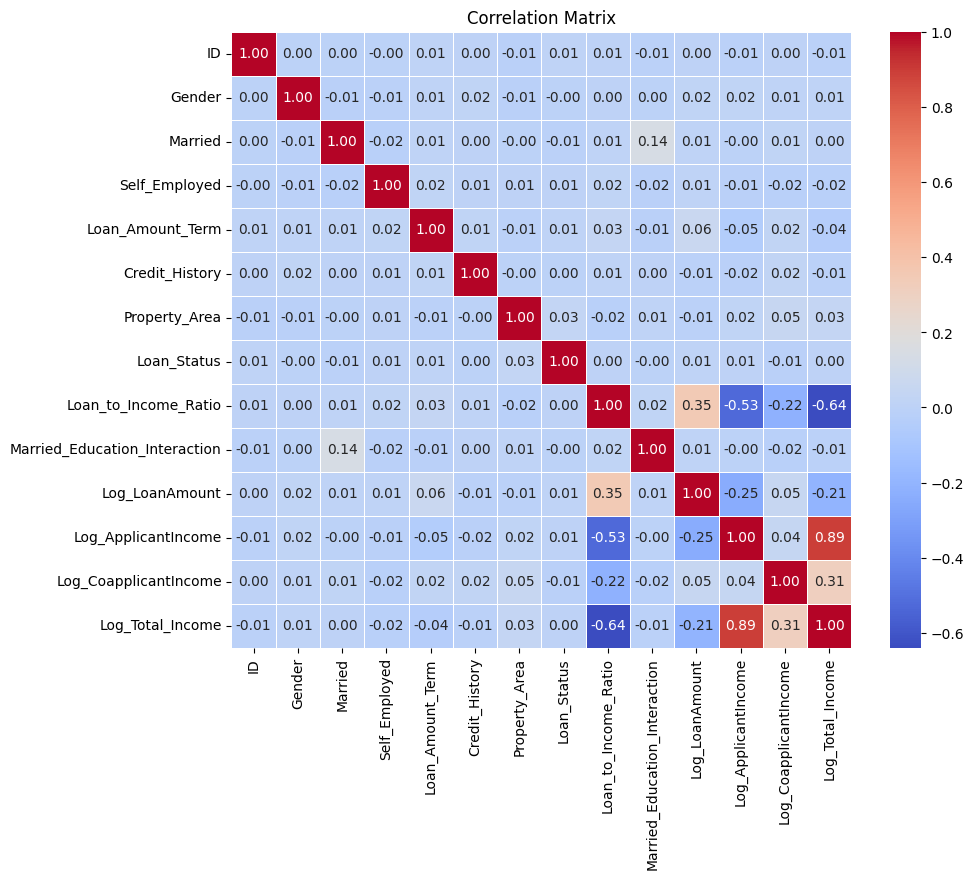

In [22]:
def cols(df):
    num_cols = df.select_dtypes(include=['float64', 'int64'])
    cat_cols = df.select_dtypes(include=['object'])
    return num_cols, cat_cols


num_column, cate_col = cols(train_df)

# Calculate the correlation matrix
correlation_matrix = num_column.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [23]:
"""# Store results
results = {}

# Iterate through each feature and exclude it
for feature in :
    features_subset = [f for f in all_features if f != feature]
    accuracy = train_and_evaluate(df_train, df_val, y_train, y_val, features_subset)
    accuracy_diff = base_accuracy - accuracy
    results[feature] = accuracy_diff
    print(f"Accuracy without {feature}: {accuracy:.4f} (Difference: {accuracy_diff:.4f})")

# Find the feature with the smallest difference
least_useful_feature = min(results, key=results.get)
print(f"\nFeature with the smallest difference in accuracy: {least_useful_feature}")"""

'# Store results\nresults = {}\n\n# Iterate through each feature and exclude it\nfor feature in :\n    features_subset = [f for f in all_features if f != feature]\n    accuracy = train_and_evaluate(df_train, df_val, y_train, y_val, features_subset)\n    accuracy_diff = base_accuracy - accuracy\n    results[feature] = accuracy_diff\n    print(f"Accuracy without {feature}: {accuracy:.4f} (Difference: {accuracy_diff:.4f})")\n\n# Find the feature with the smallest difference\nleast_useful_feature = min(results, key=results.get)\nprint(f"\nFeature with the smallest difference in accuracy: {least_useful_feature}")'

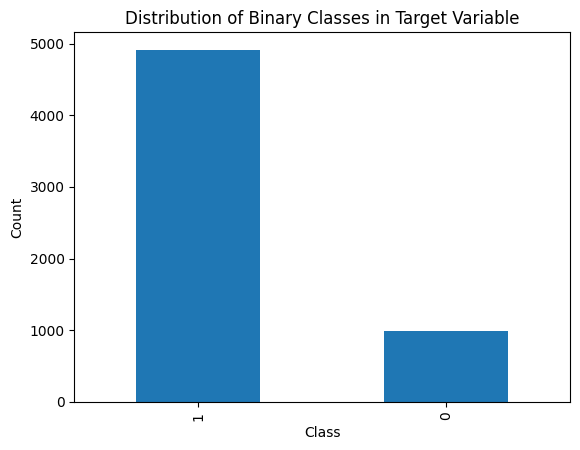

In [24]:
# Showing a high level of imbalance
target_dist = train_df['Loan_Status'].value_counts()

#Plotting the distribution
target_dist.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Binary Classes in Target Variable')
plt.show()

As seen above, there is an imbalance in our dataset, hence, we'd explore `Stratified Sampling` to ensure target distribution across split

### Feature Selection

## Data Splitting

In [25]:
# splitting into train and test
feat = ['Gender', 'Married', 'Dependents', 'Self_Employed',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area',
       'Loan_to_Income_Ratio', 'Loan_Term_Category', 'Loan_Status',
       'Married_Education_Interaction', 'Married_Education_Category',
       'Log_LoanAmount', 'Log_ApplicantIncome', 'Log_CoapplicantIncome',
       'Log_Total_Income']

X = train_df[feat].drop('Loan_Status', axis=1)
y = train_df['Loan_Status']

X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.20, random_state=42, stratify = y)


## Modeling

#### Logistic Regression

Training folds: 100%|██████████| 5/5 [00:00<00:00,  8.37it/s]


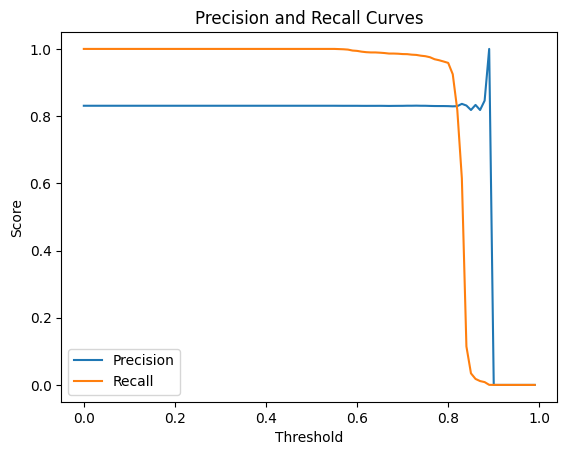

Precision and recall curves intersect at approximately threshold: 0.90


In [26]:
def train_and_validate(X, y, 
                       n_splits=5, 
                       random_state=1, 
                       solver='liblinear', 
                       penalty='l1', 
                       C=0.01, 
                       max_iter=1000,
                       plot_curves=True):

    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Initialize lists to store precision and recall scores across folds
    y_true_all = []
    y_pred_all = []
    
    # Iterate over the SK-Folds
    for train_idx, val_idx in tqdm(skfold.split(X, y), total=skfold.get_n_splits(), desc="Training folds"):
        df_train = X.iloc[train_idx]
        df_val = X.iloc[val_idx]
        
        y_train = y.iloc[train_idx].values
        y_val = y.iloc[val_idx].values

        # One-hot encode features using DictVectorizer
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(df_train.to_dict(orient='records'))
        X_val = dv.transform(df_val.to_dict(orient='records'))

        # Train the Logistic Regression model
        model = LogisticRegression(solver=solver, penalty=penalty, C=C, max_iter=max_iter)
        model.fit(X_train, y_train)

        # Predict probabilities for the validation set (positive class)
        y_val_pred_proba = model.predict_proba(X_val)[:, 1]
        
        # Store results for evaluating precision and recall
        y_true_all.extend(y_val)
        y_pred_all.extend(y_val_pred_proba)

    # Convert lists to numpy arrays
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    # Generate a range of thresholds to test
    thresholds = np.arange(0.0, 1.0, 0.01)
    pre_scores = []
    rec_scores = []
    
    # Calculate precision and recall for each threshold
    for t in thresholds:
        y_pred_binary = (y_pred_all >= t).astype(int)
        pre_scores.append(precision_score(y_true_all, y_pred_binary))
        rec_scores.append(recall_score(y_true_all, y_pred_binary))
    
    # Optionally plot the curves
    if plot_curves:
        plt.plot(thresholds, pre_scores, label='Precision')
        plt.plot(thresholds, rec_scores, label='Recall')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Precision and Recall Curves')
        plt.legend()
        plt.show()

    # Find the threshold where precision and recall are closest (i.e., minimal absolute difference)
    min_diff = float('inf')
    intersection_threshold = None
    for t, pre, rec in zip(thresholds, pre_scores, rec_scores):
        diff = abs(pre - rec)
        if diff < min_diff:
            min_diff = diff
            intersection_threshold = t

    print(f"Precision and recall curves intersect at approximately threshold: {intersection_threshold:.2f}")
    return dv, model, intersection_threshold

def predict_with_threshold(model, dv, new_data, threshold):
    # Convert new data to dictionary format and vectorize
    new_data_dict = new_data.to_dict(orient='records')
    X_new = dv.transform(new_data_dict)
    
    # Get predicted probabilities for the positive class
    proba = model.predict_proba(X_new)[:, 1]
    
    # Apply the custom threshold to get binary predictions
    predictions = (proba >= threshold).astype(int)
    return predictions


dv, model, intersection_threshold = train_and_validate(X_full_train, y_full_train, 
                       n_splits=5, 
                       random_state=1, 
                       solver='liblinear', 
                       penalty='l1', 
                       C=0.01, 
                       max_iter=1000,
                       plot_curves=True)

predictions = predict_with_threshold(model, dv, X_test, intersection_threshold)

In [27]:
def evaluate_model(model, dv, X, y, threshold):
    # Transform the data
    X_transformed = dv.transform(X.to_dict(orient='records'))
    
    # Predict probabilities for the positive class
    proba = model.predict_proba(X_transformed)[:, 1]
    
    # Apply threshold to obtain binary predictions
    predictions = (proba >= threshold).astype(int)
    
    # Compute metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    metrics = {
        "accuracy": accuracy_score(y, predictions),
        "precision": precision_score(y, predictions),
        "recall": recall_score(y, predictions),
        "f1_score": f1_score(y, predictions)
    }
    return metrics

# Example usage:
eval_metrics = evaluate_model(model, dv, X_test, y_test, intersection_threshold)
print("Evaluation Metrics on Test Set:")
for metric, value in eval_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")


Evaluation Metrics on Test Set:
Accuracy: 0.1585
Precision: 0.0000
Recall: 0.0000
F1_score: 0.0000


100%|██████████| 5/5 [00:00<00:00,  7.49it/s]


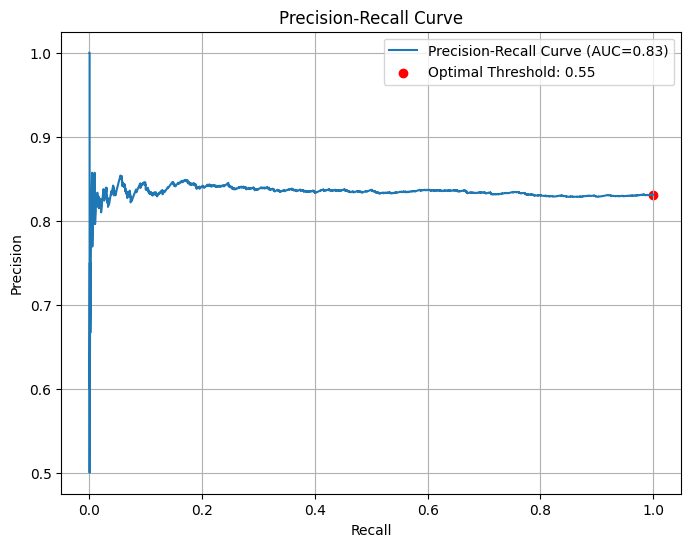

(np.float64(0.5530947595456011), np.float64(0.8344551108780689))

In [28]:
Skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Store true labels and predicted probabilities
y_true_all = []
y_pred_all = []

# Iterate over the SK-Folds
for train_idx, val_idx in tqdm(Skfold.split(X_full_train, y_full_train), total=Skfold.get_n_splits()):
    df_train = X_full_train.iloc[train_idx]
    df_val = X_full_train.iloc[val_idx]
    
    y_train = y_full_train.iloc[train_idx].values
    y_val = y_full_train.iloc[val_idx].values

    # One-hot encode categorical features
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(df_train.to_dict(orient='records'))
    X_val = dv.transform(df_val.to_dict(orient='records'))

    # Train the logistic regression model with adjusted parameters
    model = LogisticRegression(solver='liblinear', penalty='l1', C=0.01, max_iter=1000)
    model.fit(X_train, y_train)

    # Predict probabilities
    y_pred = model.predict_proba(X_val)[:, 1]
    
    # Store results
    y_true_all.extend(y_val)
    y_pred_all.extend(y_pred)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true_all, y_pred_all)
f1_scores = 2 * (precision * recall) / (precision + recall)

# Compute the optimal threshold where F1-score is maximized
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Compute PR-AUC
pr_auc = average_precision_score(y_true_all, y_pred_all)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC={pr_auc:.2f})')
plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', marker='o', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# Display optimal threshold and PR-AUC
optimal_threshold, pr_auc


CV Folds: 100%|██████████| 5/5 [00:00<00:00,  8.56it/s]


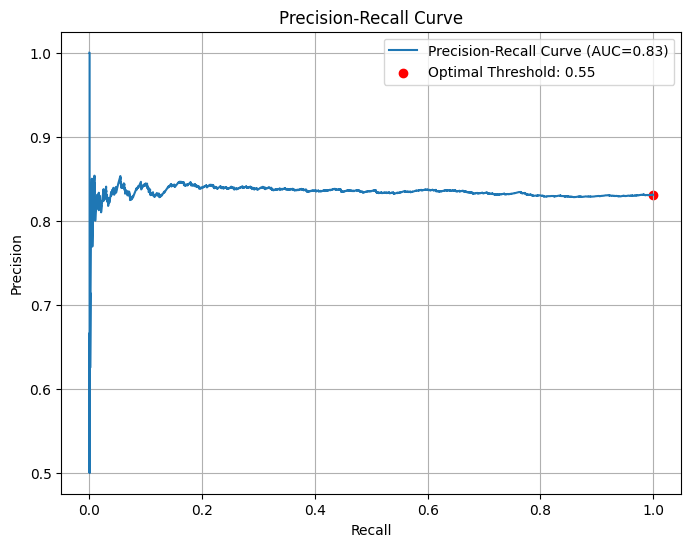

Optimal Threshold: 0.55
PR-AUC: 0.8342


CV Folds: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


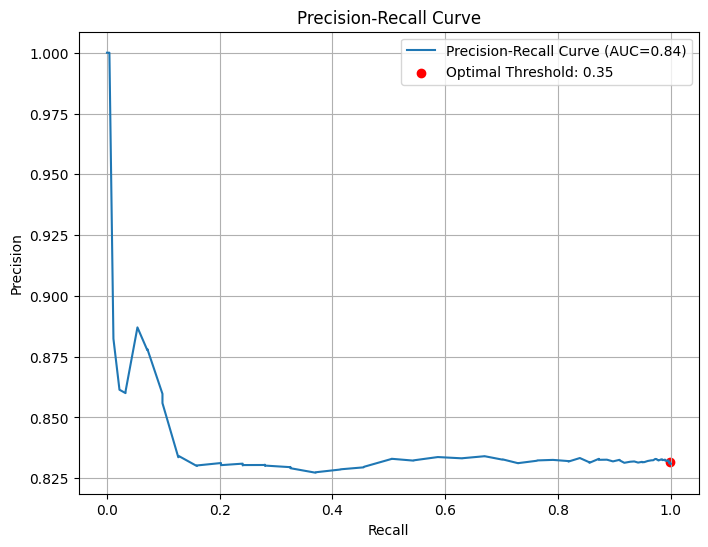

Optimal Threshold: 0.35
PR-AUC: 0.8360


CV Folds: 100%|██████████| 5/5 [00:00<00:00,  6.22it/s]


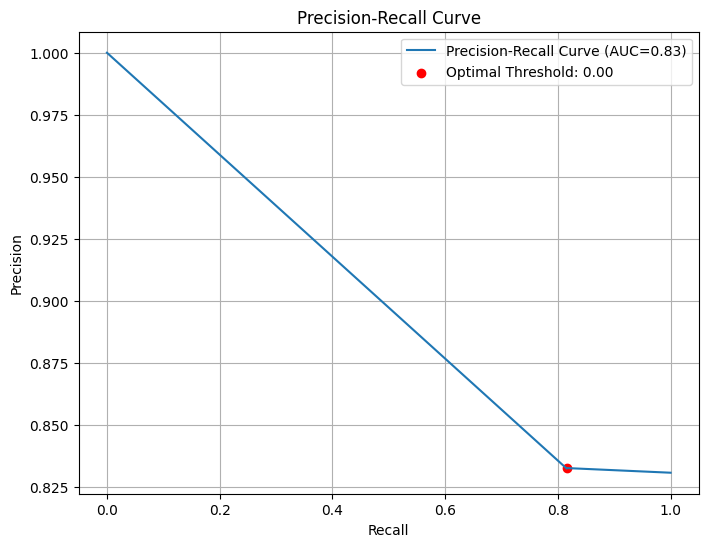

Optimal Threshold: 0.00
PR-AUC: 0.8322


CV Folds: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


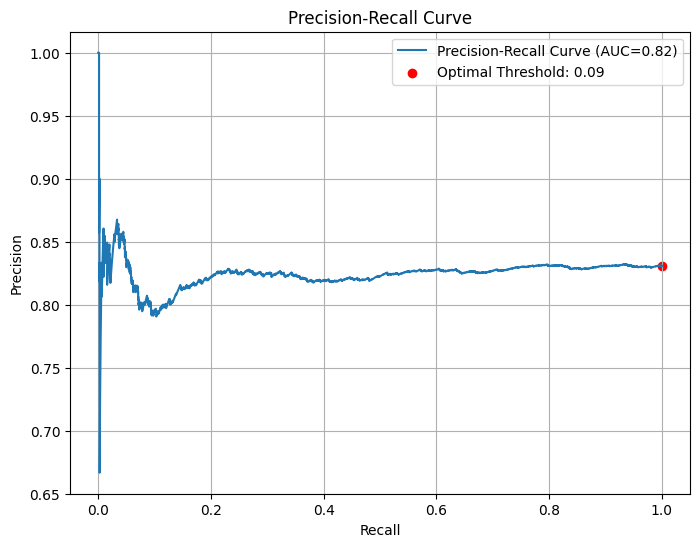

Optimal Threshold: 0.09
PR-AUC: 0.8247


CV Folds: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


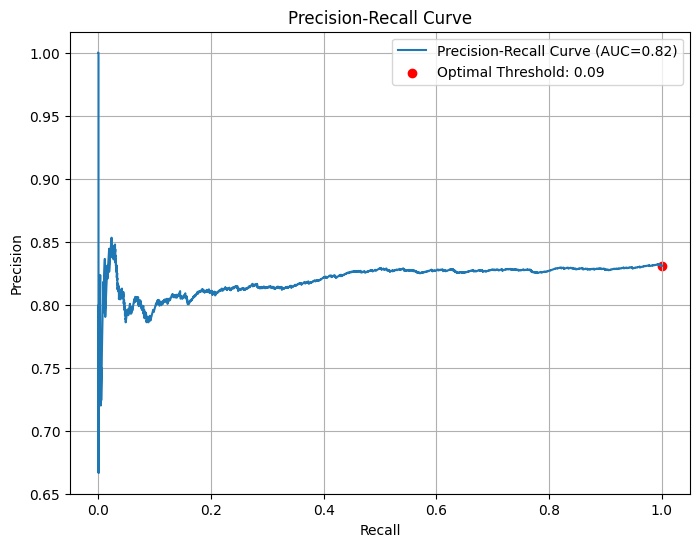

Optimal Threshold: 0.09
PR-AUC: 0.8205
Optimal Thresholds:
Logistic Regression: 0.55
Random Forest: 0.35
Decision Tree: 0.00
Gradient Boosting: 0.09
XGBoost: 0.09


In [29]:
# Define a function to compute the optimal threshold using cross-validation
def compute_optimal_threshold(model, X, y):
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    y_true_all = []
    y_pred_all = []
    
    # Iterate over the folds
    for train_idx, val_idx in tqdm(skfold.split(X, y), total=skfold.get_n_splits(), desc="CV Folds"):
        df_train = X.iloc[train_idx]
        df_val   = X.iloc[val_idx]
        
        y_train = y.iloc[train_idx].values
        y_val   = y.iloc[val_idx].values
        
        # One-hot encode features using DictVectorizer
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(df_train.to_dict(orient='records'))
        X_val   = dv.transform(df_val.to_dict(orient='records'))
        
        # Train the model on the current fold
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        
        # Collect results
        y_true_all.extend(y_val)
        y_pred_all.extend(y_pred)
    
    # Convert collected results to numpy arrays
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    
    # Compute the precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_true_all, y_pred_all)
    # Compute F1 scores at each threshold (add a tiny constant to avoid division by zero)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    # The precision_recall_curve function returns thresholds for all points except the first
    # (because precision=1 and recall=0 at threshold=0 are implicit).
    # So the f1_scores array has one extra value compared to thresholds. We use thresholds from index 0 onward.
    optimal_idx = np.argmax(f1_scores[1:])  # skip the first point if desired
    optimal_threshold = thresholds[optimal_idx]
    
    # Compute PR-AUC for reference
    pr_auc = average_precision_score(y_true_all, y_pred_all)
    
    # Plot the Precision-Recall Curve with the optimal threshold marked
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC={pr_auc:.2f})')
    plt.scatter(recall[optimal_idx+1], precision[optimal_idx+1], color='red', marker='o', 
                label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Optimal Threshold: {optimal_threshold:.2f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    
    return optimal_threshold



# Logistic Regression
lr = LogisticRegression(solver='liblinear', penalty='l1', C=0.01, max_iter=1000)
optimal_threshold_lr = compute_optimal_threshold(lr, X_full_train, y_full_train)

# Random Forest
rf = RandomForestClassifier(random_state=1)
optimal_threshold_rf = compute_optimal_threshold(rf, X_full_train, y_full_train)

# Decision Tree
dt = DecisionTreeClassifier(random_state=1)
optimal_threshold_dt = compute_optimal_threshold(dt, X_full_train, y_full_train)

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=1)
optimal_threshold_gb = compute_optimal_threshold(gb, X_full_train, y_full_train)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)
optimal_threshold_xgb = compute_optimal_threshold(xgb, X_full_train, y_full_train)

print(f"Optimal Thresholds:")
print(f"Logistic Regression: {optimal_threshold_lr:.2f}")
print(f"Random Forest: {optimal_threshold_rf:.2f}")
print(f"Decision Tree: {optimal_threshold_dt:.2f}")
print(f"Gradient Boosting: {optimal_threshold_gb:.2f}")
print(f"XGBoost: {optimal_threshold_xgb:.2f}")



# Now you can use these optimal thresholds for predicting on new/test data.
# For example:
# predictions = predict_with_threshold(model, dv, X_test, optimal_threshold_lr)


## Hybrid Calibration Method for Model Training

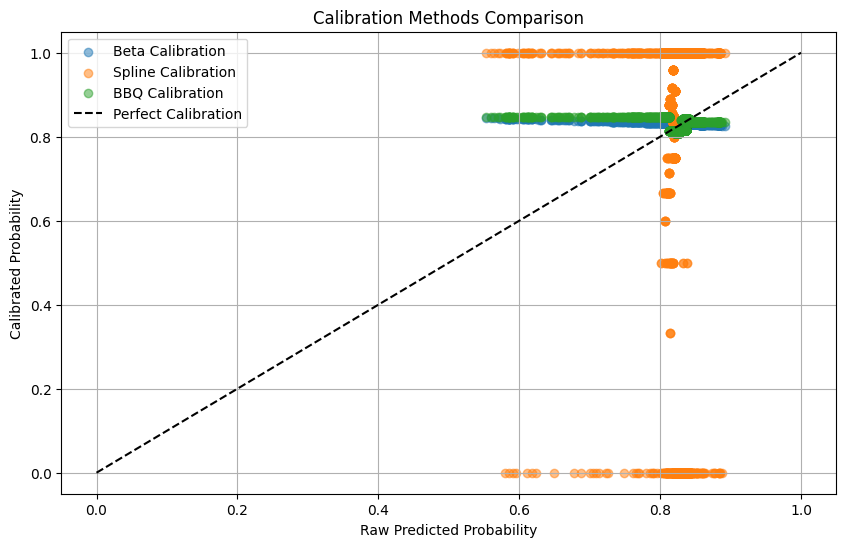

Brier Scores (lower is better):
Beta Calibration:   0.1405
Spline Calibration: 0.0097
BBQ Calibration:    0.1403
Best Calibration:   0.0097


In [30]:
# ---------------------------
# Beta Calibration
# ---------------------------
class BetaCalibration:
    def __init__(self):
        self.model = LogisticRegression(solver='lbfgs')
    
    def fit(self, s, y):
        # Clip s to avoid issues with log(0) or log(1)
        s = np.clip(s, 1e-15, 1-1e-15)
        # Create features: log(s) and log(1-s)
        X_beta = np.column_stack([np.log(s), np.log(1-s)])
        self.model.fit(X_beta, y)
        return self
    
    def predict_proba(self, s):
        s = np.clip(s, 1e-15, 1-1e-15)
        X_beta = np.column_stack([np.log(s), np.log(1-s)])
        p = self.model.predict_proba(X_beta)[:, 1]
        return p

# ---------------------------
# Spline Calibration using PCHIP
# ---------------------------
class SplineCalibration:
    def __init__(self):
        self.spline = None
    
    def fit(self, s, y):
        # Sort raw probabilities and corresponding true labels
        sorted_idx = np.argsort(s)
        s_sorted = s[sorted_idx]
        y_sorted = y[sorted_idx]
        # Get unique s values and compute the empirical positive rate for each unique value
        s_unique, idx, counts = np.unique(s_sorted, return_index=True, return_counts=True)
        empirical = np.array([np.mean(y_sorted[i:i+c]) for i, c in zip(idx, counts)])
        # Fit a monotonic spline interpolator
        self.spline = PchipInterpolator(s_unique, empirical)
        return self
    
    def predict_proba(self, s):
        calibrated = self.spline(s)
        # Ensure calibrated probabilities are within [0,1]
        calibrated = np.clip(calibrated, 0, 1)
        return calibrated

# ---------------------------
# Bayesian Binning into Quantiles (BBQ) Calibration
# ---------------------------
class BBQCalibration:
    def __init__(self, n_bins=10):
        self.n_bins = n_bins
        self.bin_edges = None
        self.bin_calib = None
    
    def fit(self, s, y):
        s = np.asarray(s)
        y = np.asarray(y)
        # Determine bin edges based on quantiles
        self.bin_edges = np.percentile(s, np.linspace(0, 100, self.n_bins + 1))
        # Ensure the edges are unique
        self.bin_edges = np.unique(self.bin_edges)
        n_bins = len(self.bin_edges) - 1
        bin_calib = []
        for i in range(n_bins):
            mask = (s >= self.bin_edges[i]) & (s < self.bin_edges[i+1])
            if np.sum(mask) == 0:
                bin_calib.append(np.nan)
            else:
                n_total = np.sum(mask)
                n_pos = np.sum(y[mask])
                # Use a uniform prior (alpha=1, beta=1)
                bin_calib.append((n_pos + 1) / (n_total + 2))
        self.bin_calib = np.array(bin_calib)
        # Replace NaN values with the overall mean from non-NaN bins
        if np.any(np.isnan(self.bin_calib)):
            mean_val = np.nanmean(self.bin_calib)
            self.bin_calib = np.where(np.isnan(self.bin_calib), mean_val, self.bin_calib)
        return self
    
    def predict_proba(self, s):
        s = np.asarray(s)
        # Find the appropriate bin index for each raw probability
        indices = np.searchsorted(self.bin_edges, s, side='right') - 1
        indices = np.clip(indices, 0, len(self.bin_calib) - 1)
        calibrated = self.bin_calib[indices]
        return calibrated


np.random.seed(42)

y_true = y_true_all
y_pred_raw = y_pred_all



# Fit Calibration Methods
beta_cal = BetaCalibration().fit(y_pred_raw, y_true)
spline_cal = SplineCalibration().fit(y_pred_raw, y_true)
bbq_cal = BBQCalibration(n_bins=10).fit(y_pred_raw, y_true)

# Get calibrated probabilities from each method
cal_beta = beta_cal.predict_proba(y_pred_raw)
cal_spline = spline_cal.predict_proba(y_pred_raw)
cal_bbq = bbq_cal.predict_proba(y_pred_raw)

# Plot Calibration Comparison

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_raw, cal_beta, label='Beta Calibration', alpha=0.5)
plt.scatter(y_pred_raw, cal_spline, label='Spline Calibration', alpha=0.5)
plt.scatter(y_pred_raw, cal_bbq, label='BBQ Calibration', alpha=0.5)
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Raw Predicted Probability')
plt.ylabel('Calibrated Probability')
plt.title('Calibration Methods Comparison')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Evaluate Calibration with Brier Score
# ---------------------------
brier_beta = brier_score_loss(y_true, cal_beta)
brier_spline = brier_score_loss(y_true, cal_spline)
brier_bbq = brier_score_loss(y_true, cal_bbq)

print("Brier Scores (lower is better):")
print(f"Beta Calibration:   {brier_beta:.4f}")
print(f"Spline Calibration: {brier_spline:.4f}")
print(f"BBQ Calibration:    {brier_bbq:.4f}")
print(f"Best Calibration:   {min(brier_beta, brier_spline, brier_bbq):.4f}")

CV Folds: 100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


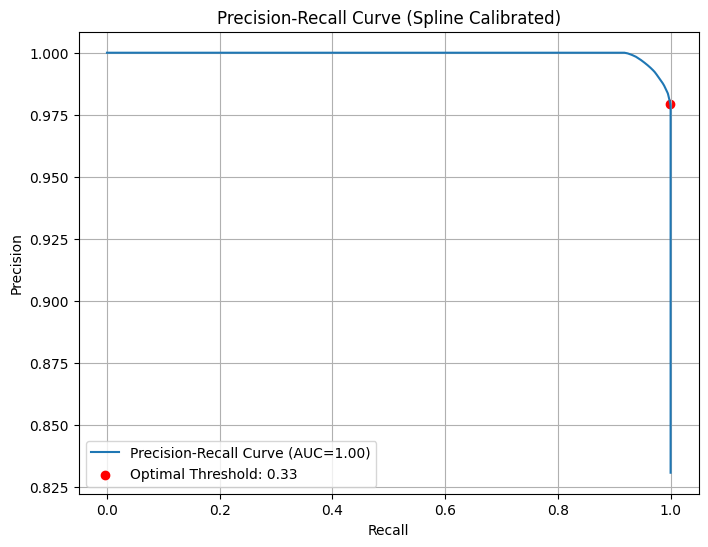

Optimal Threshold (Spline Calibrated): 0.33
PR-AUC (Spline Calibrated): 0.9994


CV Folds: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


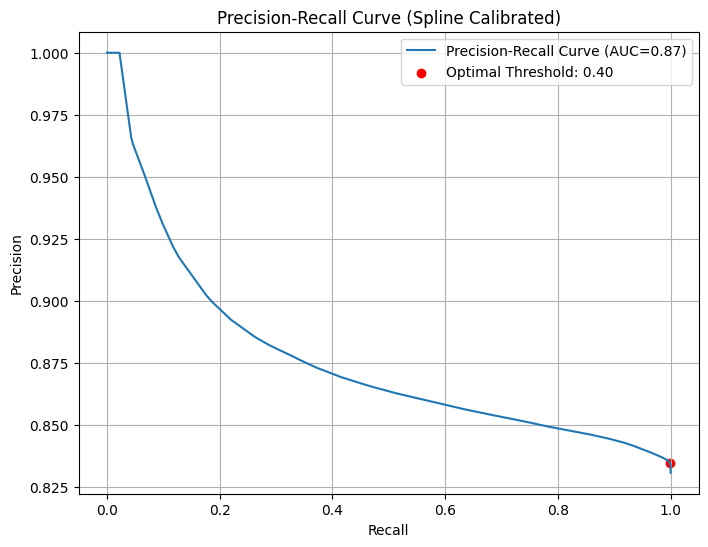

Optimal Threshold (Spline Calibrated): 0.40
PR-AUC (Spline Calibrated): 0.8741


CV Folds: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]


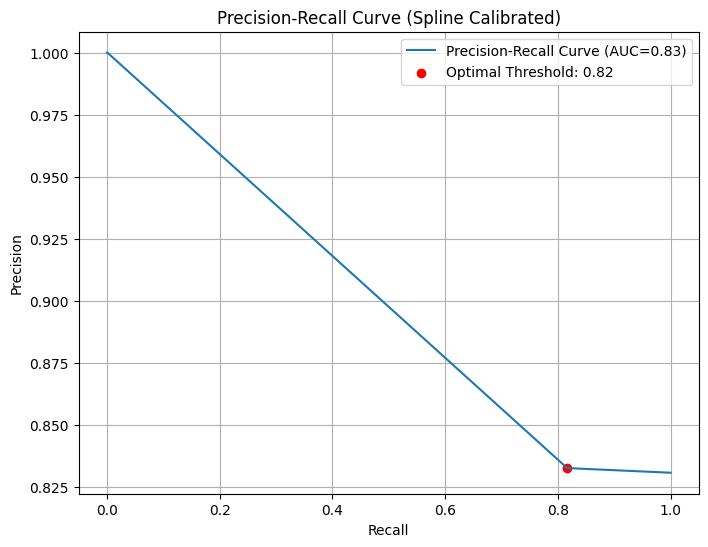

Optimal Threshold (Spline Calibrated): 0.82
PR-AUC (Spline Calibrated): 0.8326


CV Folds: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


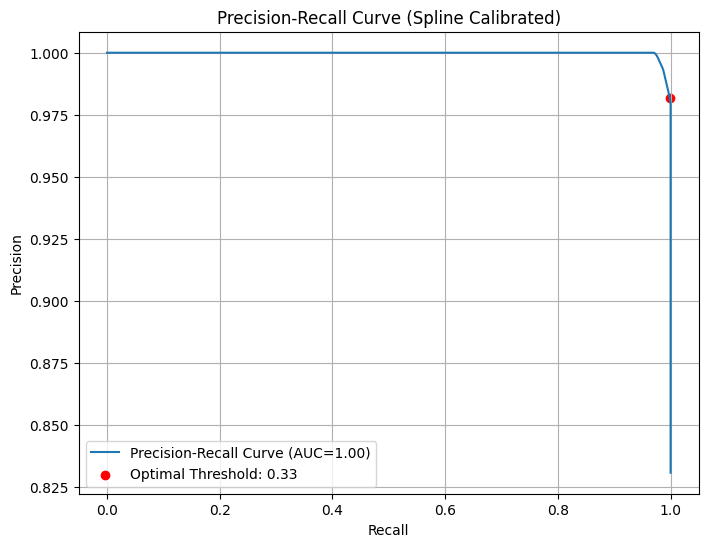

Optimal Threshold (Spline Calibrated): 0.33
PR-AUC (Spline Calibrated): 0.9997


CV Folds: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


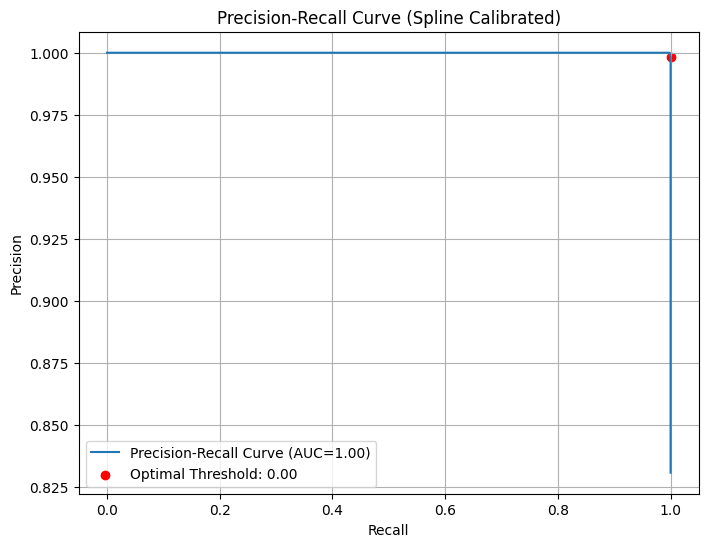

Optimal Threshold (Spline Calibrated): 0.00
PR-AUC (Spline Calibrated): 1.0000
Optimal Thresholds (Spline Calibrated):
Logistic Regression: 0.33
Random Forest:       0.40
Decision Tree:       0.82
Gradient Boosting:   0.33
XGBoost:             0.00


In [31]:
def compute_optimal_threshold(model, X, y):

    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    y_true_all = []
    y_pred_all = []
    
    # Iterate over folds
    for train_idx, val_idx in tqdm(skfold.split(X, y), total=skfold.get_n_splits(), desc="CV Folds"):
        df_train = X.iloc[train_idx]
        df_val   = X.iloc[val_idx]
        
        y_train = y.iloc[train_idx].values
        y_val   = y.iloc[val_idx].values
        
        # One-hot encode features using DictVectorizer
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(df_train.to_dict(orient='records'))
        X_val   = dv.transform(df_val.to_dict(orient='records'))
        
        # Train the model on the current fold
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        
        # Collect results
        y_true_all.extend(y_val)
        y_pred_all.extend(y_pred)
    
    # Convert lists to arrays
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    
    # ------------------------------
    # Apply Spline Calibration
    # ------------------------------
    spline_cal = SplineCalibration().fit(y_pred_all, y_true_all)
    y_pred_calibrated = spline_cal.predict_proba(y_pred_all)
    
    # Compute the precision-recall curve using calibrated probabilities
    precision, recall, thresholds = precision_recall_curve(y_true_all, y_pred_calibrated)
    
    # Compute F1 scores at each threshold (avoid division by zero)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    # Note: precision_recall_curve returns one extra value for f1_scores (first point is implicit)
    optimal_idx = np.argmax(f1_scores[1:])  # Skip the first point if desired
    optimal_threshold = thresholds[optimal_idx]
    
    # Compute PR-AUC for reference
    pr_auc = average_precision_score(y_true_all, y_pred_calibrated)
    
    # Plot the Precision-Recall Curve with the optimal threshold marked
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC={pr_auc:.2f})')
    # Adjust index by 1 since we skipped the first point
    plt.scatter(recall[optimal_idx+1], precision[optimal_idx+1], color='red', marker='o', 
                label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Spline Calibrated)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Optimal Threshold (Spline Calibrated): {optimal_threshold:.2f}")
    print(f"PR-AUC (Spline Calibrated): {pr_auc:.4f}")
    
    return optimal_threshold



# Logistic Regression
lr = LogisticRegression(solver='liblinear', penalty='l1', C=0.01, max_iter=1000)
optimal_threshold_lr = compute_optimal_threshold(lr, X_full_train, y_full_train)

# Random Forest
rf = RandomForestClassifier(random_state=1)
optimal_threshold_rf = compute_optimal_threshold(rf, X_full_train, y_full_train)

# Decision Tree
dt = DecisionTreeClassifier(random_state=1)
optimal_threshold_dt = compute_optimal_threshold(dt, X_full_train, y_full_train)

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=1)
optimal_threshold_gb = compute_optimal_threshold(gb, X_full_train, y_full_train)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)
optimal_threshold_xgb = compute_optimal_threshold(xgb, X_full_train, y_full_train)


# Print the Optimal Thresholds for Each Model (Spline Calibrated)

print("Optimal Thresholds (Spline Calibrated):")
print(f"Logistic Regression: {optimal_threshold_lr:.2f}")
print(f"Random Forest:       {optimal_threshold_rf:.2f}")
print(f"Decision Tree:       {optimal_threshold_dt:.2f}")
print(f"Gradient Boosting:   {optimal_threshold_gb:.2f}")
print(f"XGBoost:             {optimal_threshold_xgb:.2f}")

## Final Model Trainning

CV Folds: 100%|██████████| 5/5 [00:00<00:00,  9.40it/s]


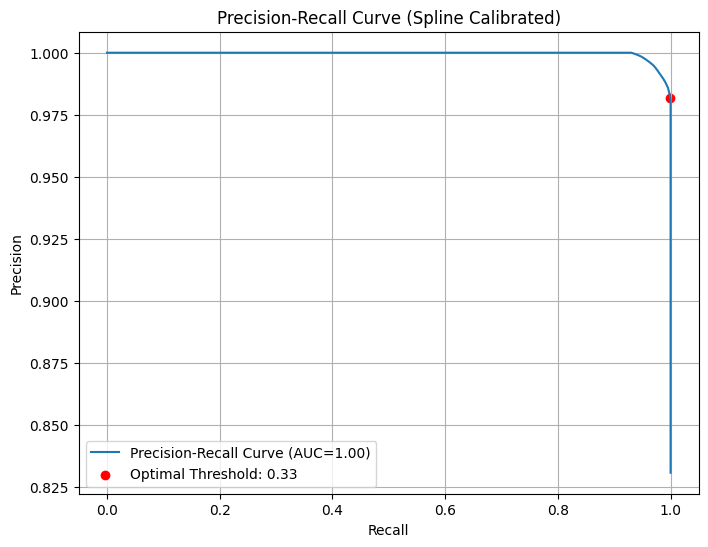

Optimal Threshold (Spline Calibrated): 0.33
PR-AUC (Spline Calibrated): 0.9996


CV Folds: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


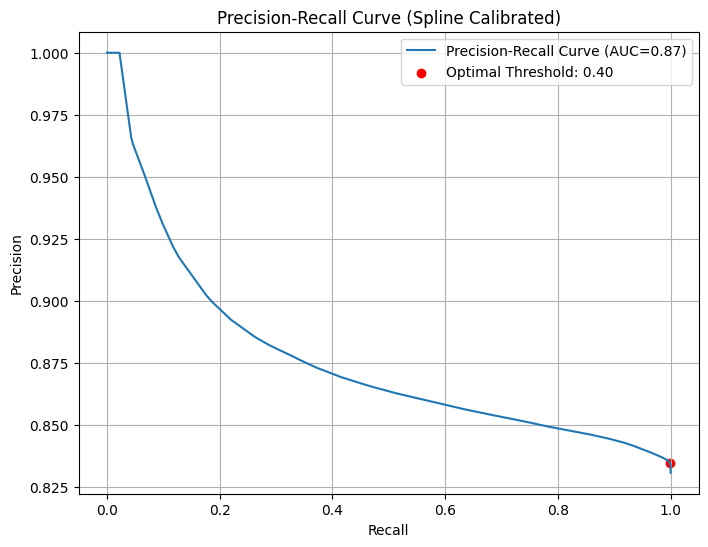

Optimal Threshold (Spline Calibrated): 0.40
PR-AUC (Spline Calibrated): 0.8741


CV Folds: 100%|██████████| 5/5 [00:00<00:00,  7.64it/s]


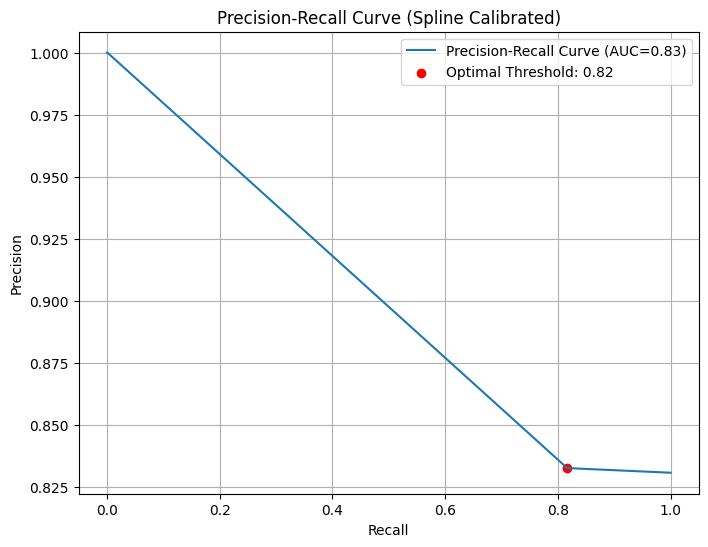

Optimal Threshold (Spline Calibrated): 0.82
PR-AUC (Spline Calibrated): 0.8326


CV Folds: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


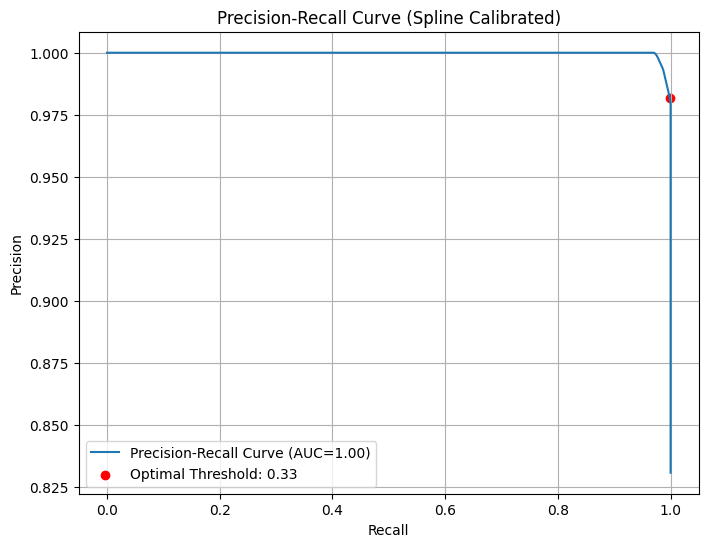

Optimal Threshold (Spline Calibrated): 0.33
PR-AUC (Spline Calibrated): 0.9997


CV Folds: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


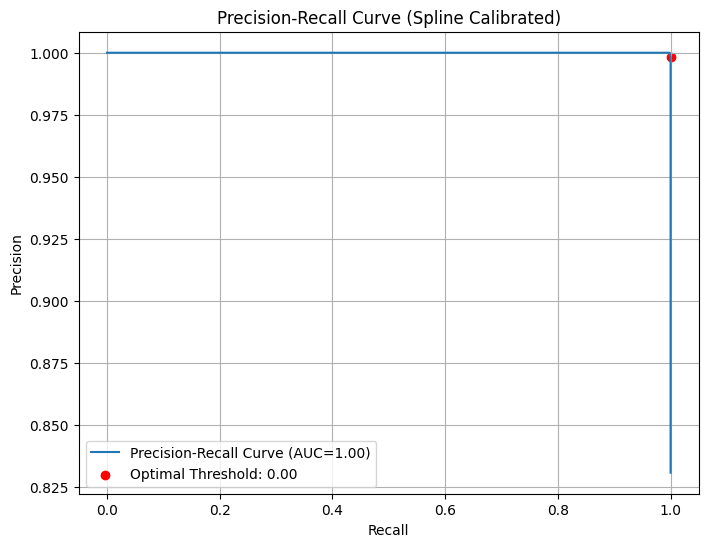

Optimal Threshold (Spline Calibrated): 0.00
PR-AUC (Spline Calibrated): 1.0000
Optimal Thresholds (Spline Calibrated):
Logistic Regression: 0.33
Random Forest:       0.40
Decision Tree:       0.82
Gradient Boosting:   0.33
XGBoost:             0.00


In [32]:
# ------------------------------------------------------------------
# Compute Optimal Threshold Function (using Spline Calibration)
# ------------------------------------------------------------------
def compute_optimal_threshold(model, X, y):
    """
    Performs stratified 5-fold cross-validation on X and y, one-hot encodes features via DictVectorizer,
    trains the provided model, and collects raw predicted probabilities.
    Then applies Spline Calibration to the aggregated probabilities, computes the precision-recall curve
    and corresponding F1 scores, and selects the threshold that maximizes F1 (skipping the first point).
    Plots the precision-recall curve (with the optimal threshold marked) and returns the optimal threshold.
    """
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    y_true_all = []
    y_pred_all = []
    
    # Iterate over folds
    for train_idx, val_idx in tqdm(skfold.split(X, y), total=skfold.get_n_splits(), desc="CV Folds"):
        df_train = X.iloc[train_idx]
        df_val   = X.iloc[val_idx]
        
        y_train = y.iloc[train_idx].values
        y_val   = y.iloc[val_idx].values
        
        # One-hot encode features using DictVectorizer
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(df_train.to_dict(orient='records'))
        X_val   = dv.transform(df_val.to_dict(orient='records'))
        
        # Train the model on the current fold
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        
        # Collect results
        y_true_all.extend(y_val)
        y_pred_all.extend(y_pred)
    
    # Convert collected results to numpy arrays
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    
    # ------------------------------
    # Apply Spline Calibration
    # ------------------------------
    spline_cal = SplineCalibration().fit(y_pred_all, y_true_all)
    y_pred_calibrated = spline_cal.predict_proba(y_pred_all)
    
    # Compute the precision-recall curve using calibrated probabilities
    precision, recall, thresholds = precision_recall_curve(y_true_all, y_pred_calibrated)
    
    # Compute F1 scores at each threshold (avoid division by zero)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    # precision_recall_curve returns thresholds for all points except the first (implicit point at threshold=0)
    # Skip the first F1 score (index 0) for threshold selection
    optimal_idx = np.argmax(f1_scores[1:])  # optimal index among thresholds[0:]
    optimal_threshold = thresholds[optimal_idx]
    
    # Compute PR-AUC for reference
    pr_auc = average_precision_score(y_true_all, y_pred_calibrated)
    
    # Plot the Precision-Recall Curve with the optimal threshold marked
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC={pr_auc:.2f})')
    # Adjust index by 1 since we skipped the first point
    plt.scatter(recall[optimal_idx+1], precision[optimal_idx+1], color='red', marker='o', 
                label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Spline Calibrated)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Optimal Threshold (Spline Calibrated): {optimal_threshold:.2f}")
    print(f"PR-AUC (Spline Calibrated): {pr_auc:.4f}")
    
    return optimal_threshold

# ------------------------------------------------------------------
# Function to Train Final Model on Full Training Data
# ------------------------------------------------------------------
def train_final_model(model, X, y):
  
    dv = DictVectorizer(sparse=False)
    X_transformed = dv.fit_transform(X.to_dict(orient='records'))
    model.fit(X_transformed, y)
    return model, dv

# ------------------------------------------------------------------
# Evaluation Function for a Single Model
# ------------------------------------------------------------------
def evaluate_model(model, dv, X, y, threshold):

    X_transformed = dv.transform(X.to_dict(orient='records'))
    proba = model.predict_proba(X_transformed)[:, 1]
    predictions = (proba >= threshold).astype(int)
    
    metrics = {
        "accuracy": accuracy_score(y, predictions),
        "precision": precision_score(y, predictions),
        "recall": recall_score(y, predictions),
        "f1_score": f1_score(y, predictions)
    }
    return metrics

# ------------------------------------------------------------------
# Compute Optimal Thresholds Using Spline Calibration (via CV) for Each Model
# ------------------------------------------------------------------
optimal_thresh_lr = compute_optimal_threshold(
    LogisticRegression(solver='liblinear', penalty='l1', C=0.01, max_iter=1000),
    X_full_train, y_full_train)

optimal_thresh_rf = compute_optimal_threshold(
    RandomForestClassifier(random_state=1),
    X_full_train, y_full_train)

optimal_thresh_dt = compute_optimal_threshold(
    DecisionTreeClassifier(random_state=1),
    X_full_train, y_full_train)

optimal_thresh_gb = compute_optimal_threshold(
    GradientBoostingClassifier(random_state=1),
    X_full_train, y_full_train)

optimal_thresh_xgb = compute_optimal_threshold(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1),
    X_full_train, y_full_train)

print("Optimal Thresholds (Spline Calibrated):")
print(f"Logistic Regression: {optimal_thresh_lr:.2f}")
print(f"Random Forest:       {optimal_thresh_rf:.2f}")
print(f"Decision Tree:       {optimal_thresh_dt:.2f}")
print(f"Gradient Boosting:   {optimal_thresh_gb:.2f}")
print(f"XGBoost:             {optimal_thresh_xgb:.2f}")

In [33]:
# ------------------------------------------------------------------
# Retrain Final Models on the Full Training Data
# ------------------------------------------------------------------
model_lr_final, dv_lr_final = train_final_model(
    LogisticRegression(solver='liblinear', penalty='l1', C=0.01, max_iter=1000),
    X_full_train, y_full_train)

model_rf_final, dv_rf_final = train_final_model(
    RandomForestClassifier(random_state=1),
    X_full_train, y_full_train)

model_dt_final, dv_dt_final = train_final_model(
    DecisionTreeClassifier(random_state=1),
    X_full_train, y_full_train)

model_gb_final, dv_gb_final = train_final_model(
    GradientBoostingClassifier(random_state=1),
    X_full_train, y_full_train)

model_xgb_final, dv_xgb_final = train_final_model(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1),
    X_full_train, y_full_train)

# ------------------------------------------------------------------
# Dictionary of Final Models and Their Optimal Thresholds
# ------------------------------------------------------------------
models_info = {
    "Logistic Regression": (model_lr_final, dv_lr_final, optimal_threshold_lr),
    "Random Forest": (model_rf_final, dv_rf_final, optimal_threshold_rf),
    "Decision Tree": (model_dt_final, dv_dt_final, optimal_threshold_dt),
    "Gradient Boosting": (model_gb_final, dv_gb_final, optimal_threshold_gb),
    "XGBoost": (model_xgb_final, dv_xgb_final, optimal_threshold_xgb)
}

## Model Evaluation

In [34]:
print("\nEvaluation Metrics on Test Set:")
print("=" * 40)
for model_name, (model, dv, threshold) in models_info.items():
    metrics = evaluate_model(model, dv, X_test, y_test, threshold)
    print(f"{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric.capitalize()}: {value:.4f}")
    print("-" * 40)


Evaluation Metrics on Test Set:
Logistic Regression:
  Accuracy: 0.8415
  Precision: 0.8415
  Recall: 1.0000
  F1_score: 0.9139
----------------------------------------
Random Forest:
  Accuracy: 0.8381
  Precision: 0.8416
  Recall: 0.9950
  F1_score: 0.9119
----------------------------------------
Decision Tree:
  Accuracy: 0.6975
  Precision: 0.8326
  Recall: 0.8016
  F1_score: 0.8168
----------------------------------------
Gradient Boosting:
  Accuracy: 0.8398
  Precision: 0.8413
  Recall: 0.9980
  F1_score: 0.9129
----------------------------------------
XGBoost:
  Accuracy: 0.8415
  Precision: 0.8415
  Recall: 1.0000
  F1_score: 0.9139
----------------------------------------
